In [127]:
import cv2
import numpy as np
import torch

from misc_functions import get_params, save_class_activation_on_image

class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x

class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_index=None):
        # Full forward pass
        # conv_output: output of convolutions at specified layer
        # model_output: final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
#         print(conv_output, model_output)
        print(conv_output.shape, model_output.shape)
        
        if target_index is None: 
            target_index = np.argmax(model_output.data.numpy())
        
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_index] = 1
        
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        
        print('guided_gradients:', guided_gradients.shape)
        
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = cv2.resize(cam, (224, 224))
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        
        return cam

target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_params(target_example)

# grad_cam = GradCam(pretrained_model, target_layer=11)
# cam = grad_cam.generate_cam(prep_img, target_class)
# save_class_activation_on_image(original_image, cam, file_name_to_export)
# print('Grad cam completed')

In [128]:
import sys
sys.path.append('/blanca/workspace/blanca/utils')
import libraries
from utils_global import *
%matplotlib inline

print(original_image.shape, prep_img.shape, target_class, file_name_to_export)
print(pretrained_model)

(224, 224, 3) torch.Size([1, 3, 224, 224]) 56 snake
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (

In [3]:
## CAM GENERATION

Layer: 0
torch.Size([1, 64, 55, 55]) torch.Size([1, 1000])
guided_gradients: (64, 55, 55)


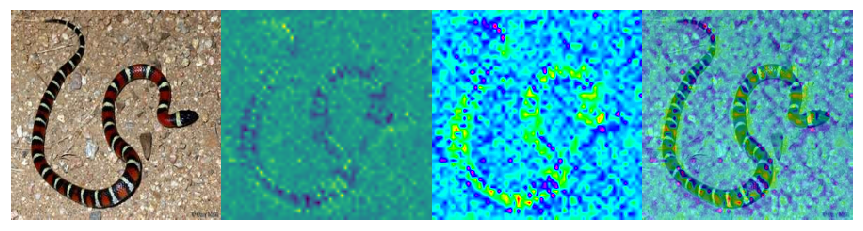

Layer: 1
torch.Size([1, 64, 55, 55]) torch.Size([1, 1000])
guided_gradients: (64, 55, 55)


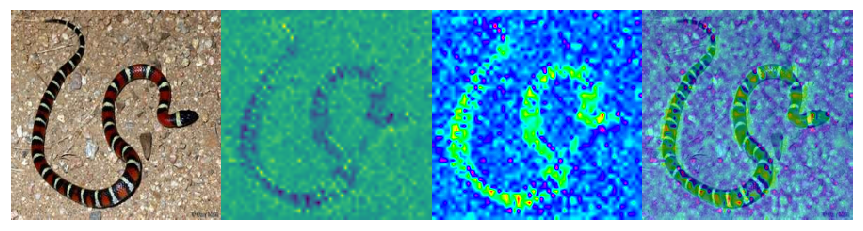

Layer: 2
torch.Size([1, 64, 27, 27]) torch.Size([1, 1000])
guided_gradients: (64, 27, 27)


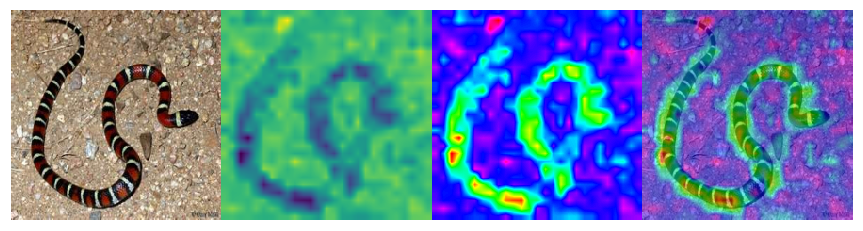

Layer: 3
torch.Size([1, 192, 27, 27]) torch.Size([1, 1000])
guided_gradients: (192, 27, 27)


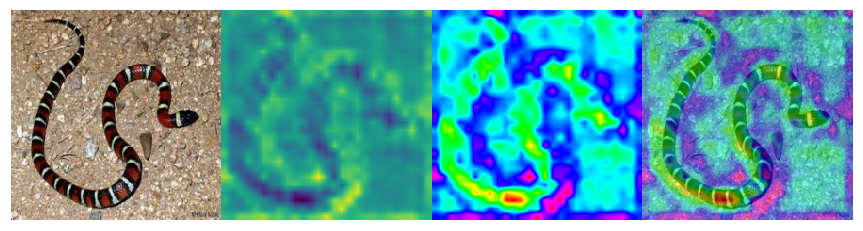

Layer: 4
torch.Size([1, 192, 27, 27]) torch.Size([1, 1000])
guided_gradients: (192, 27, 27)


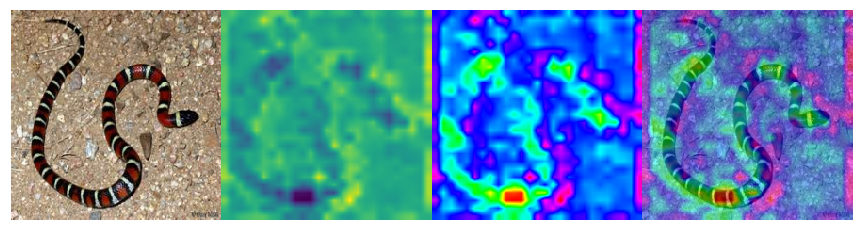

Layer: 5
torch.Size([1, 192, 13, 13]) torch.Size([1, 1000])
guided_gradients: (192, 13, 13)


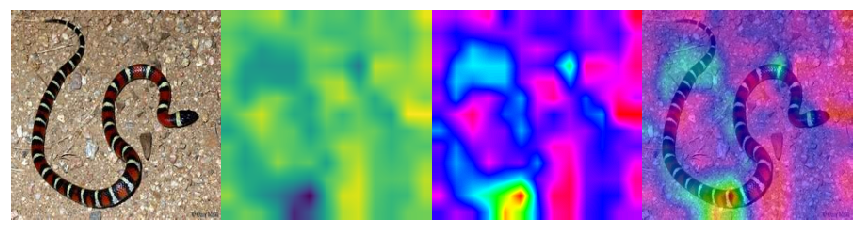

Layer: 6
torch.Size([1, 384, 13, 13]) torch.Size([1, 1000])
guided_gradients: (384, 13, 13)


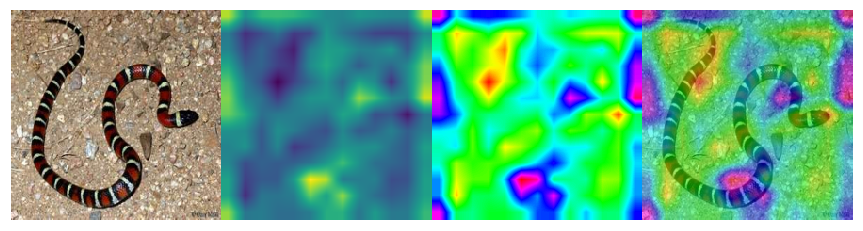

Layer: 7
torch.Size([1, 384, 13, 13]) torch.Size([1, 1000])
guided_gradients: (384, 13, 13)


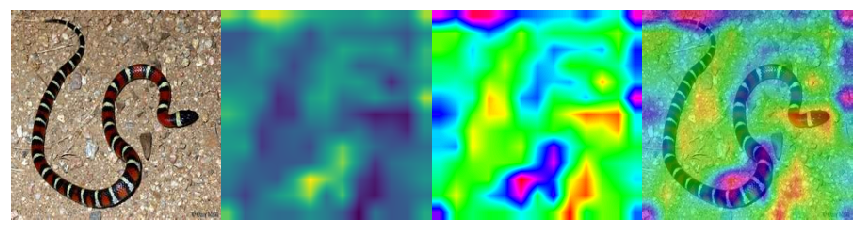

Layer: 8
torch.Size([1, 256, 13, 13]) torch.Size([1, 1000])
guided_gradients: (256, 13, 13)


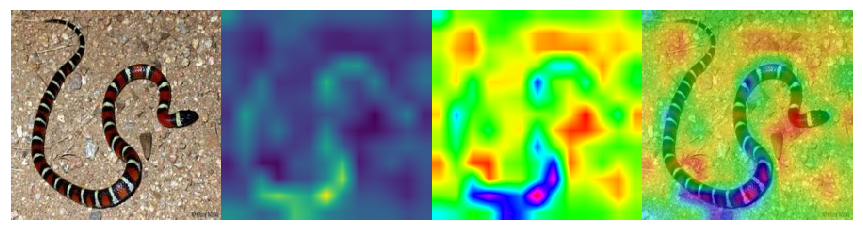

Layer: 9
torch.Size([1, 256, 13, 13]) torch.Size([1, 1000])
guided_gradients: (256, 13, 13)


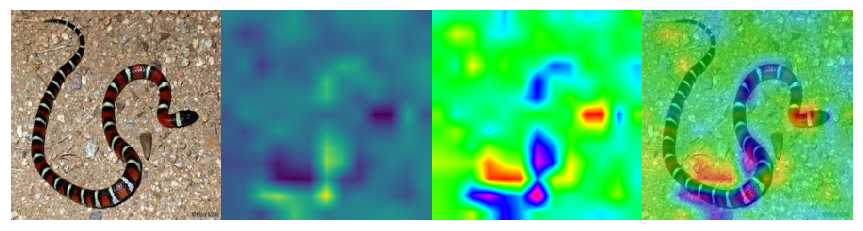

Layer: 10
torch.Size([1, 256, 13, 13]) torch.Size([1, 1000])
guided_gradients: (256, 13, 13)


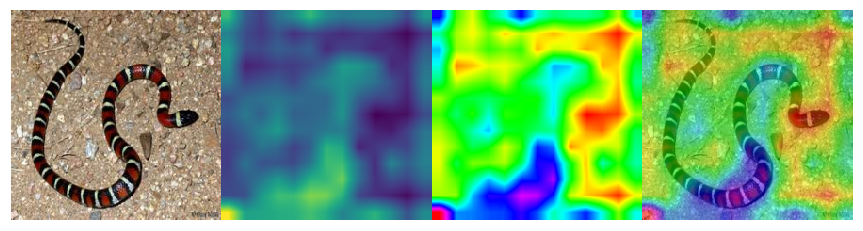

Layer: 11
torch.Size([1, 256, 13, 13]) torch.Size([1, 1000])
guided_gradients: (256, 13, 13)


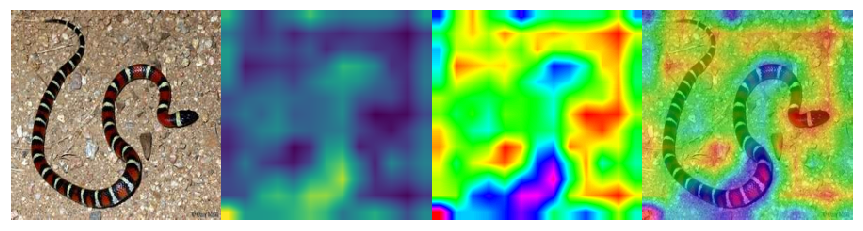

Layer: 12
torch.Size([1, 256, 6, 6]) torch.Size([1, 1000])
guided_gradients: (256, 6, 6)


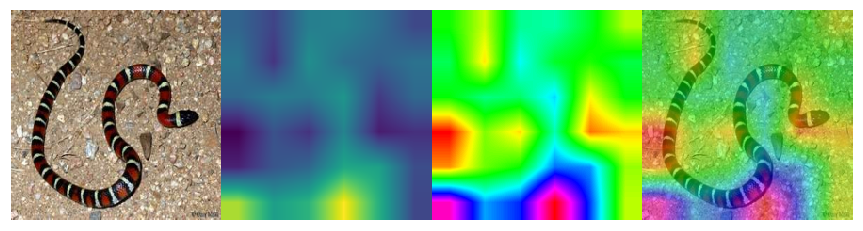

In [4]:
for i in pretrained_model.features._modules.keys(): 
    print('Layer:', i)
    grad_cam = GradCam(pretrained_model, target_layer=int(i))
    cam = grad_cam.generate_cam(prep_img, target_class)
    cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_HSV)
    im_with_cam_color = np.float32(cam_color) + np.float32(original_image)
    im_with_cam_color = im_with_cam_color / np.max(im_with_cam_color)

    ims = [original_image, cam, cam_color, im_with_cam_color]
    plot_ims(ims)

In [41]:
## GUIDED BACKPROP

In [5]:
import torch
from torch.nn import ReLU
from misc_functions import (get_params,
                            convert_to_grayscale,
                            save_gradient_images,
                            get_positive_negative_saliency)

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model, processed_im, target_class):
        self.model = model
        self.input_image = processed_im
        self.target_class = target_class
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that it only returns positive gradients
        """
        def relu_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, changes it to zero
            """
            if isinstance(module, ReLU):
                return (torch.clamp(grad_in[0], min=0.0),)
        # Loop through layers, hook up ReLUs with relu_hook_function
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_hook_function)

    def generate_gradients(self):
        # Forward pass
        model_output = self.model(self.input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][self.target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


In [ ]:
## EXAMPLE OF GRADIENTS WITH BACKPROP

target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_params(target_example)

# Guided backprop
GBP = GuidedBackprop(pretrained_model, prep_img, target_class)
# Get gradients
guided_grads = GBP.generate_gradients()
# Save colored gradients
# save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
# save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps

pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
# save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
# save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Guided backprop completed')

Data dimensions not supported
Data dimensions not supported


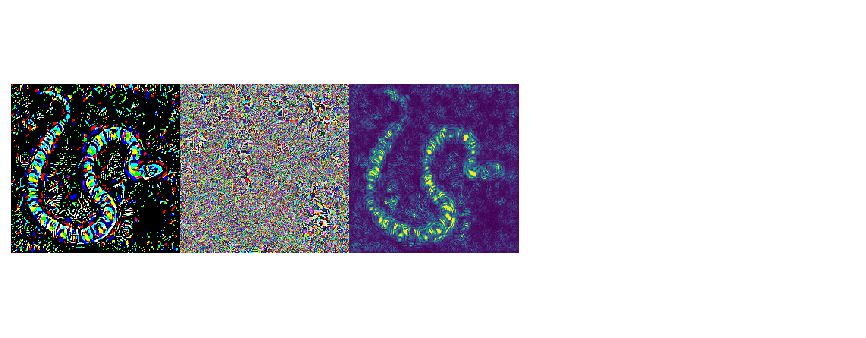

In [71]:
im_guided_grads = guided_grads.transpose((1, 2, 0))  #* 255
im_guided_grads_norm = ((guided_grads.transpose((1, 2, 0)) / 2) + 0.5) *255
im_grayscale_guided_grads = grayscale_guided_grads[0] #.transpose((1, 2, 0)) #* 255
im_pos_sal = pos_sal.transpose((1, 2, 0)) * 255
im_neg_sal = neg_sal.transpose((1, 2, 0)) * 255

ims = [im_guided_grads, im_guided_grads_norm, im_grayscale_guided_grads, pos_sal, neg_sal]
plot_ims(ims)

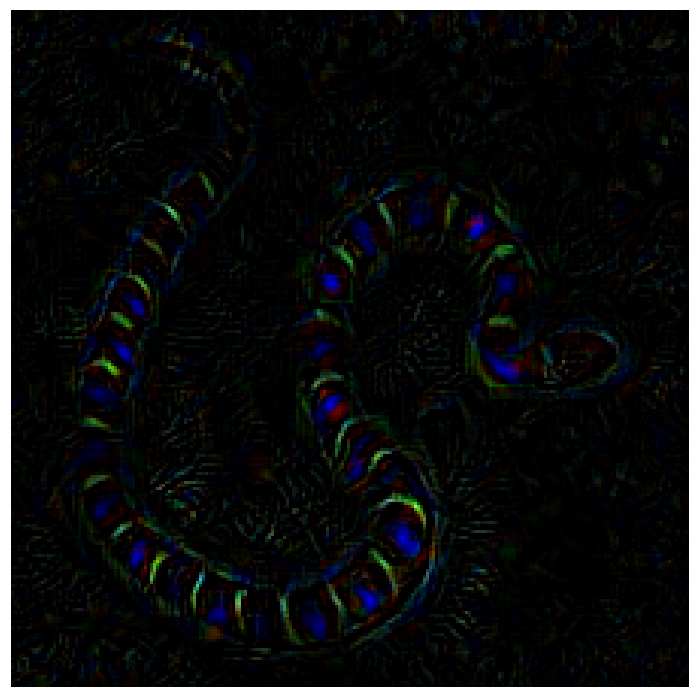

In [72]:
im_guided_grads = ((guided_grads.transpose((1, 2, 0)) * 255))
# print(np.max(im_guided_grads))

im_guided_grads = ((guided_grads.transpose((1, 2, 0)) / 2) + 0.5) *255
# print(np.max(im_guided_grads))

im_pos_sal = pos_sal.transpose((1, 2, 0)) * 255
plot_im(im_pos_sal)

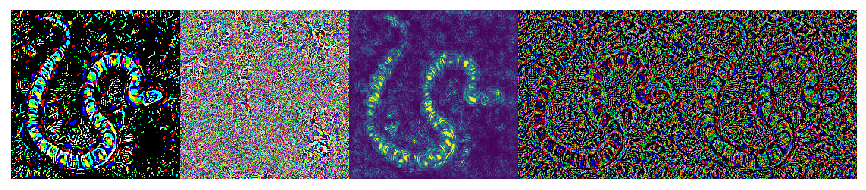

In [105]:
from misc_functions import convert_to_grayscale, save_gradient_images
from guided_backprop import GuidedBackprop

def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
        Guided grad cam is just pointwise multiplication of cam mask and
        guided backprop mask

    Args:
        grad_cam_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb

target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_params(target_example)

gcv2 = GradCam(pretrained_model, target_layer=11)
cam = gcv2.generate_cam(prep_img, target_class)
print('Grad cam completed')

GBP = GuidedBackprop(pretrained_model, prep_img, target_class)
guided_grads = GBP.generate_gradients()
print('Guided backpropagation completed')

cam_gb = guided_grad_cam(cam, guided_grads)
#     save_gradient_images(cam_gb, file_name_to_export + '_GGrad_Cam')
#     grayscale_cam_gb = convert_to_grayscale(cam_gb)
#     save_gradient_images(grayscale_cam_gb, file_name_to_export + '_GGrad_Cam_gray')
#     print('Guided grad cam completed')

torch.Size([1, 256, 13, 13]) torch.Size([1, 1000])
Grad cam completed
Guided backpropagation completed


In [124]:
# plot_im(cam_gb.transpose((1, 2, 0)))
guided_grads.shape
np.max(guided_grads)

0.10540352

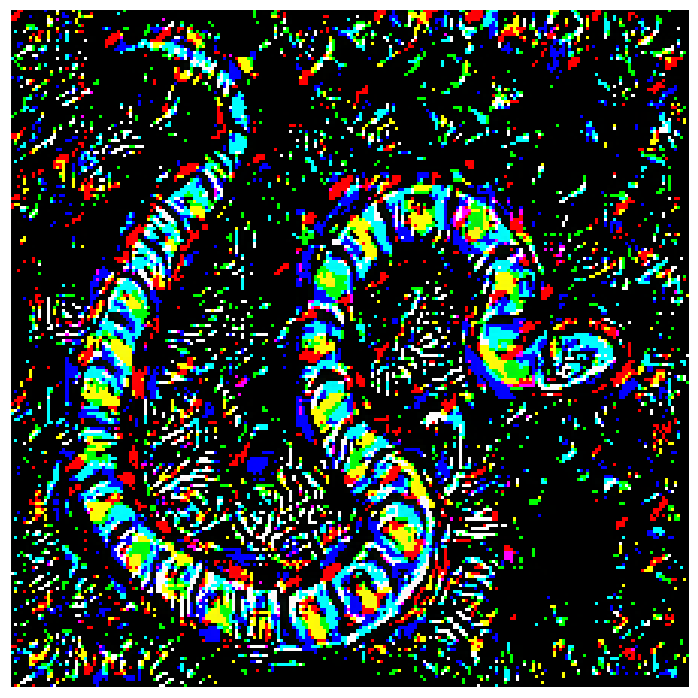

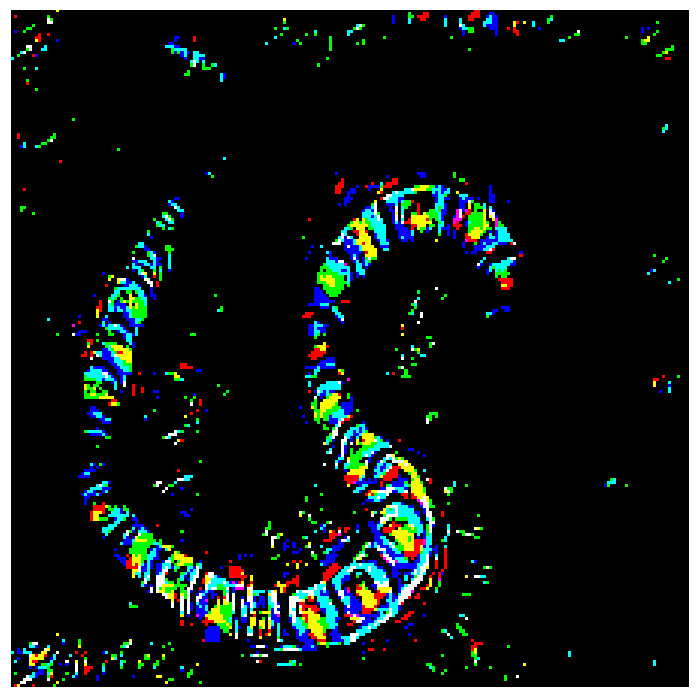

In [129]:
plot_im((255 * guided_grads).transpose((1, 2, 0)))
plot_im(cam_gb.transpose((1, 2, 0)))

In [ ]:
## TESTING IN P2PHD DISCRIMINATOR

In [244]:
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0, tensor=torch.FloatTensor):
        super(GANLoss, self).__init__()
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        self.real_label_var = None
        self.fake_label_var = None
        self.Tensor = tensor
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCEWithLogitsLoss() # nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        target_tensor = None
        if target_is_real:
            create_label = ((self.real_label_var is None) or
                            (self.real_label_var.numel() != input.numel()))
            if create_label:
                real_tensor = self.Tensor(input.size()).fill_(self.real_label)
                self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            create_label = ((self.fake_label_var is None) or
                            (self.fake_label_var.numel() != input.numel()))
            if create_label:
                fake_tensor = self.Tensor(input.size()).fill_(self.fake_label)
                self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        return target_tensor

    def __call__(self, input, target_is_real):
        if isinstance(input[0], list):
            loss = 0
            for input_i in input:
                pred = input_i[-1]
                target_tensor = self.get_target_tensor(pred, target_is_real)
                # print(len(input_i), pred.shape, target_tensor.shape)
                # print(pred.data.min())
                loss += self.loss(pred, target_tensor)
            return loss
        else:
            # print(input.shape)
            target_tensor = self.get_target_tensor(input[-1], target_is_real)
            return self.loss(input[-1], target_tensor)

In [247]:
import functools
import torch.nn as nn
from networks import *
# import networks_utils
# from networks_utils import *

# VIS GAN
D_MODEL_PATH = '/blanca/workspace/blanca/project/wip/pix2pixHDX-class-master/checkpoints/test_X/200_net_D.pth'
G_MODEL_PATH = '/blanca/workspace/blanca/project/wip/pix2pixHDX-class-master/checkpoints/test_X/200_net_G.pth'
G_MODEL_PATH = '/blanca/workspace/blanca/project/wip/pix2pixHDX-class-master/checkpoints/clean_G_class_10_D/100_net_G.pth'
D_MODEL_PATH = '/blanca/workspace/blanca/project/wip/pix2pixHDX-class-master/checkpoints/clean_G_class_10_D/100_net_D.pth'

def define_G(input_nc, output_nc, ngf, n_downsample_global=4, n_blocks_global=9, n_local_enhancers=1,
             n_blocks_local=3, norm='instance'):

    norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=True)
    netG = GlobalGenerator(input_nc, output_nc, ngf, n_downsample_global, n_blocks_global, norm_layer)
    return netG

def define_D(input_nc, ndf, n_layers_D, norm='instance', use_sigmoid=False, num_D=2, getIntermFeat=True):
    
    norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=True)
    netD = MultiscaleDiscriminator(input_nc, ndf, n_layers_D, norm_layer, use_sigmoid, num_D, getIntermFeat)
    return netD

input_nc, output_nc, ngf, n_downsample_global, n_blocks_global, n_local_enhancers, n_blocks_local = 3, 3, 64, 4, 9, 1, 3
netG = define_G(input_nc, output_nc, ngf, n_downsample_global, n_blocks_global, n_local_enhancers, n_blocks_local)
netG.load_state_dict(torch.load(G_MODEL_PATH))

input_nc, ndf, n_layers_D, num_D = 6, 64, 3, 2
netD = define_D(input_nc, ndf, n_layers_D, num_D)
netD.load_state_dict(torch.load(D_MODEL_PATH))

criterionGAN = GANLoss(use_lsgan=True, tensor=torch.Tensor)

In [267]:
criterionGAN
netD

MultiscaleDiscriminator(
  (scale0_layer0): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(0.2, inplace)
  )
  (scale0_layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): LeakyReLU(0.2, inplace)
  )
  (scale0_layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): LeakyReLU(0.2, inplace)
  )
  (scale0_layer3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): LeakyReLU(0.2, inplace)
  )
  (scale0_layer4): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
  (scal

In [227]:
di_v_path = '/blanca'
project_path = 'workspace/blanca/project/wip/pix2pixHDX-class-master'
import sys, os
sys.path.append(os.path.join(di_v_path, project_path))

# import importlib
# importlib.reload(data)

from data.base_dataset import BaseDataset, get_params, get_transform, normalize
from data.base_dataset import fill_gaps, read_image_OpenCV, resize_image_OpenCV, load_original_mask

from data.image_folder import make_dataset
# custom functions
from data.image_folder import create_dataset, create_dataset_withLabel, create_dataset_fromIDsubfolders, create_dataset_fromIDsubfolders_withLabel 

import os.path
import torch
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path

class Options():
    def __init__(self):
        self.dataroot = '/blanca/workspace/blanca/training_datasets/pix2pix/'
        self.dataset_list = ['images_target_clean_classified', 'video_target_clean_classified']
        self.isTrain = True
        self.label_nc = 0
        self.output_nc = 3
        self.loadSize = 256
        self.fill = 'W&B'
        self.no_lsgan = False
    
class AlignedDataset(BaseDataset):
        
    def initialize(self, opt):
        self.opt = opt
        self.root = opt.dataroot    
        self.dataset_list = opt.dataset_list

        self.target_paths = []
        if self.opt.isTrain:
            self.target_paths += create_dataset_withLabel(os.path.join(self.root, self.dataset_list[0])); print(len(self.target_paths))
            self.target_paths += create_dataset_fromIDsubfolders_withLabel(os.path.join(self.root, self.dataset_list[1]), nitems=2); print(len(self.target_paths))
        else:
            # self.target_paths += create_dataset(os.path.join(self.root, self.dataset_list[0]))
            self.target_paths += make_dataset(os.path.join(self.root, self.dataset_list[0])); print(self.target_paths)
            
        self.dataset_size = len(self.target_paths) 
        
        if True: 
            self.images_mask_path = Path('../../../training_datasets/pix2pix/images_mask')
            self.images_mask_fname_list = [i.parts[-1] for i in list(self.images_mask_path.glob('*.png'))]
            
    def apply_data_transforms(self, im, which, opt, nchannels=None):
        
        transform_list = []
        if which == 'target':
            transform_list += [
                    transforms.Lambda(lambda x: fill_gaps(x, opt, fill_input_with='average')),
                    transforms.Lambda(lambda x: x[:, :, :nchannels]),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    ]
                
        elif which == 'targetXC':
             transform_list += [
                    transforms.Lambda(lambda x: x[:, :, :nchannels]),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                    ]
    
        elif which == 'input':        
            transform_list += [
                transforms.Lambda(lambda x: x.copy()),
                transforms.Lambda(lambda x: fill_gaps(x, opt, add_artificial=opt.isTrain)),
                # drops the compose&blended image alpha channel and loads the original one:
                transforms.Lambda(lambda x: load_original_mask(x, nchannels == 4, opt,
                                                               self.target_path, 
                                                               self.images_mask_fname_list, 
                                                               self.images_mask_path)),
                transforms.Lambda(lambda x: x[:, :, :nchannels]),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ]
            
        elif which == 'mask':        
            transform_list += [
                transforms.Lambda(lambda x: x.copy()),
                transforms.Lambda(lambda x: load_original_mask(x, nchannels == 4, opt,
                                                               self.target_path,
                                                               self.images_mask_fname_list,
                                                               self.images_mask_path)),
                transforms.Lambda(lambda x: fill_gaps(x, opt, only_extract_mask=True)),
                # transforms.Lambda(lambda x: resize_image_OpenCV(x, (224, 224))),

                transforms.Lambda(lambda x: x[:, :, 3]),
                    ]                                    
                                         
        return transforms.Compose(transform_list)(im)
    
    
    def __getitem__(self, index):                             
        
        target_tensor = target_label_tensor = inst_tensor = feat_tensor = target4C_tensor = target_mask_tensor = 0
        
        input_nc = self.opt.label_nc if self.opt.label_nc != 0 else 3
        output_nc = self.opt.output_nc
        
        # read target image
        if self.opt.isTrain:
                self.target_path = self.target_paths[index][0]
                target_label = self.target_paths[index][1]
        else: self.target_path = self.target_paths[index]
                
        target_im = read_image_OpenCV(self.target_path, self.opt)
        target_im_resized = read_image_OpenCV(self.target_path, self.opt, target_size=(224, 224))
                
        # create input tensor first
        # if self.opt.isTrain:
        input_tensor = self.apply_data_transforms(target_im, 'input', self.opt, input_nc)
        # just for visualization purposes (check that the original alpha channel is loaded properly):
        input_mask_tensor = self.apply_data_transforms(target_im, 'mask', self.opt, input_nc)  
        
        # create output tensor
        if self.opt.isTrain: 
                
                # target image (image label) for the GAN
                target_tensor = self.apply_data_transforms(target_im, 'target', self.opt, output_nc)
                # target image with alpha channel
                target4C_tensor = self.apply_data_transforms(target_im_resized, 'targetXC', self.opt, nchannels=4)
                # good/bad fit label
                target_label_tensor = torch.FloatTensor([target_label])
                
                # delete?:
                # target image alpha channel to append to the output of G, and before entering the classifier
                # target_mask_tensor = self.apply_data_transforms(target_im, 'mask', self.opt)
        
        input_dict = {'input': input_tensor, 'inst': inst_tensor, 
                      'target': target_tensor, 'feat': feat_tensor, 
                      'target4C': target4C_tensor, 'input_mask': input_mask_tensor,
                      'path': self.target_path, 'label': target_label_tensor}

        return input_dict
    
    def __get_x_item__(self, index):
        return self.__getitem__(index)
    
    def __len__(self):
        return len(self.target_paths)

    def name(self):
        return 'AlignedDataset'

# load and tansform image
im_path = '/workspace/blanca/training_datasets/pix2pix/images_target_clean_classified/bad_fit/300w01_indoor_015.png'
im_path = os.path.join(di_v_path, im_path)

opt = Options()
dataset =  AlignedDataset()
dataset.initialize(opt)

# data_loader = CreateDataLoader(opt)
# dataset = data_loader.load_data()
# dataset_size = len(data_loader)
# print('#training images = %d' % dataset_size)

x = dataset.__get_x_item__(0)

shuffling...done
shuffling...done
shuffling...done
2222
Total found IDs in path /blanca/workspace/blanca/training_datasets/pix2pix/video_target_clean_classified/good_fit: 49 .. and selected 2 per ID
shuffling...done
2326


In [228]:
def preprocess_image(cv2im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (Pytorch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        cv2im = cv2.resize(cv2im, (224, 224))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

input
inst
target
feat
target4C
input_mask
path
label
(256, 256, 3) (256, 256, 3) (256, 256)


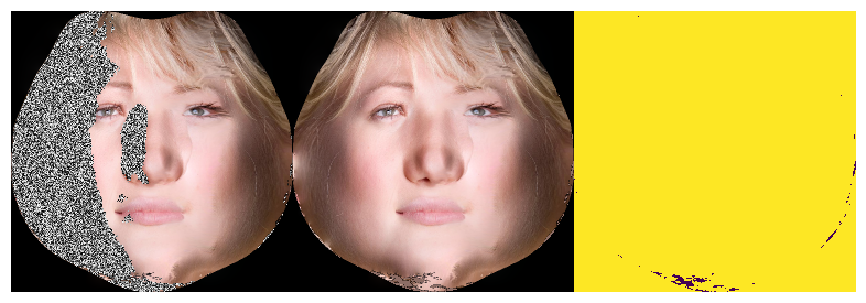

In [229]:
import sys
from importlib import reload
sys.path.append('/blanca/workspace/blanca/utils')
import libraries
import utils_global
reload(utils_global)

from utils_global import *
%matplotlib inline


x = dataset.__get_x_item__(0)
for k, v in x.items(): print(k)

im_input = ((x['input'].data.numpy().transpose((1, 2, 0)) / 2) + 0.5) * 255
im_target = ((x['target'].data.numpy().transpose((1, 2, 0)) / 2) + 0.5) * 255
im_mask = x['input_mask']

print(im_input.shape, im_target.shape, im_mask.shape)
plot_ims([im_input, im_target, im_mask], alpha=True)

In [230]:
input_D.shape

x_input = x['input'].expand(1, x['input'].shape[0], x['input'].shape[1], x['input'].shape[2])
x_target = x['target'].expand(1, x['target'].shape[0], x['target'].shape[1], x['target'].shape[2])

print(x_input.shape, x_target.shape)

input_D = torch.cat((x_input, x_target), dim=1)

print(input_D.shape)

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])
torch.Size([1, 6, 256, 256])


In [231]:
# layers = []
# netD._modules.keys()
# for i in netD._modules.keys(): 
#     print(i)
# #     model_layers.append(netD._modules[i])
#     block = netD._modules[i]._modules
#     for i in block.keys():
#         layer = block[i]
#         layers.append((i, block[i]))

# layers

In [131]:
model = pretrained_model   
target_layer = 11
conv_output = None
# x = image
for module_pos, module in model.features._modules.items():
    print(module_pos, module)
#     x = module(x)  # Forward
#     if int(module_pos) == target_layer:
#         print(module_pos)
#         x.register_hook(self.save_gradient)
#         conv_output = x  # Save the convolution output on that layer


0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
1 ReLU(inplace)
2 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
4 ReLU(inplace)
5 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
6 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 ReLU(inplace)
8 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 ReLU(inplace)
10 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace)
12 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)


In [258]:
model = netD
for block_name, block in model._modules.items():
    for module_pos, module in block._modules.items():
        print(block_name, module_pos, module)

scale0_layer0 0 Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
scale0_layer0 1 LeakyReLU(0.2, inplace)
scale0_layer1 0 Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
scale0_layer1 1 InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
scale0_layer1 2 LeakyReLU(0.2, inplace)
scale0_layer2 0 Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
scale0_layer2 1 InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
scale0_layer2 2 LeakyReLU(0.2, inplace)
scale0_layer3 0 Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
scale0_layer3 1 InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
scale0_layer3 2 LeakyReLU(0.2, inplace)
scale0_layer4 0 Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
scale1_layer0 0 Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
scale1_layer0 1 LeakyReLU(0.2, inplace)
sc

In [266]:
import cv2
import numpy as np
import torch

from misc_functions import get_params, save_class_activation_on_image

class CamExtractorD():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        
        for block_name, block in self.model._modules.items():
            for module_pos, module in block._modules.items():
                print(module_pos, module)
                x = module(x)  # Forward
                if int(module_pos) == self.target_layer:
                    x.register_hook(self.save_gradient)
                    conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        print(x.shape)
        x = x.view(x.size(0), -1)  # Flatten
        print(x.shape)
        # Forward pass on the classifier
#         x = self.model.classifier(x)
        x = criterionGAN(x, True)
    
        return conv_output, x

class GradCamD():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractorD(self.model, target_layer)

    def generate_cam(self, input_image, target_index=None):
        # Full forward pass
        # conv_output: output of convolutions at specified layer
        # model_output: final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        print('FORWARD:', conv_output.shape, model_output.shape)
        
        if target_index is None: 
            target_index = np.argmax(model_output.data.numpy())
        
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_index] = 1
        
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        
        print('guided_gradients:', guided_gradients.shape)
        
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = cv2.resize(cam, (224, 224))
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        
        return cam

prep_img = input_D
pretrained_model = netD

for block_name, block in pretrained_model._modules.items():
    for i, module in block._modules.items(): 
        if block_name[:6] == 'scale0':
            print(block_name, module_pos, module)
            grad_cam = GradCamD(pretrained_model, target_layer=int(i))
            
            cam = grad_cam.generate_cam(prep_img, True)

#             cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_HSV)
#             im_with_cam_color = np.float32(cam_color) + np.float32(original_image)
#             im_with_cam_color = im_with_cam_color / np.max(im_with_cam_color)

#             ims = [original_image, cam, cam_color, im_with_cam_color]
#             plot_ims(ims)

scale0_layer0 0 Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
0 Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
1 LeakyReLU(0.2, inplace)
0 Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
1 InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
2 LeakyReLU(0.2, inplace)
0 Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
1 InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
2 LeakyReLU(0.2, inplace)
0 Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
1 InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
2 LeakyReLU(0.2, inplace)
0 Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
0 Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))


RuntimeError: Given groups=1, weight[64, 6, 4, 4], so expected input[1, 1, 35, 35] to have 6 channels, but got 1 channels instead

In [252]:
pretrained_model._modules.items()

odict_items([('scale0_layer0', Sequential(
  (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (1): LeakyReLU(0.2, inplace)
)), ('scale0_layer1', Sequential(
  (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): LeakyReLU(0.2, inplace)
)), ('scale0_layer2', Sequential(
  (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): LeakyReLU(0.2, inplace)
)), ('scale0_layer3', Sequential(
  (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): LeakyReLU(0.2, inplace)
)), ('scale0_layer4', Sequential(
  (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
)), ('scale1_layer0', Sequential(
  (0): Conv2d(6, 6